### 特征介绍
笔试数据介绍：每个`csv`文件对应一段时间的数据，每个文件内的数据间隔一小时，且`time`代表了该 时间段的起始时间  
open：开盘价  
close：闭盘价  
high：最高价  
low：最低价  
volumefrom: 成交量  
volumeto：交易额  
conversionType与conversionSymbol尚不清楚  

### 模型训练思路
- 去掉缺失值过多的特征，即conversionType和conversionSymbol；
- 添加新特征交易价格 volumevalue = volumeto/volumefrom；
- 采用LSTM(Long Short Term Memory)处理时间序列的预测问题，预测股票闭盘价格；
- 采用15个时间点数据(`mem_data`)预测10个时间点(`pre_sec`)后的闭盘价格，其中`pre_sec`可自主决定，`mem_data`通过模型调节得到

### 待优化
- 解决闭盘价格预测滞后问题；
- 解决可调整时间段长短的滚动训练(目前只训练了最后1小时的数据)；
- 自动计算股票收益率并决策买卖时间；


# 获取所有时间段内的股票数据

In [19]:
import os
import numpy as np
import pandas as pd
from collections import deque
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler,StandardScaler

import tensorflow as tf
from keras.layers import Dropout
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import LSTM, Dense, Dropout 

In [21]:
files = [i for i in os.listdir('./data') if i.endswith('.csv')]
files.sort() # 将所有数据按照时间排序
print(f'共有{len(files)}个时间段的股票数据')
df = pd.read_csv('data/'+files[-1]) # 只取出了之后一段数据
print(df.info())

共有29个时间段的股票数据
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2001 entries, 0 to 2000
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   time              2001 non-null   int64  
 1   high              2001 non-null   float64
 2   low               2001 non-null   float64
 3   open              2001 non-null   float64
 4   volumefrom        2001 non-null   float64
 5   volumeto          2001 non-null   float64
 6   close             2001 non-null   float64
 7   conversionType    2001 non-null   object 
 8   conversionSymbol  5 non-null      object 
dtypes: float64(6), int64(1), object(2)
memory usage: 140.8+ KB
None


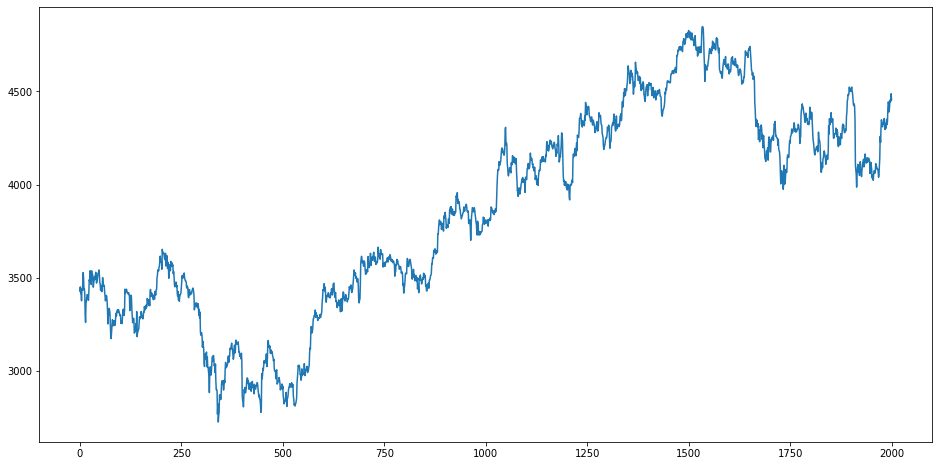

In [23]:
# 股票闭盘价格可视化
plt.figure(figsize=(16,8))
plt.plot(df['close'])

# 数据处理

In [27]:
def stock_price_data_processing(df, pre_sec, mem_data):
    '''
    df:DataFrame格式数据
    pre_sec：预测多少个时间点后
    mem_data：用多少组输入数据进行预测
    '''
    df = df[['high','low','open','volumefrom','volumeto','close']]
    df = df.dropna() # 去除空值
    df['volumevalue'] = df['volumeto']/df['volumefrom']
    df['label'] = df['close'].shift(-pre_sec) # label是10个时间点后的闭盘价格
    scaler = StandardScaler()
    sca_X = scaler.fit_transform(df.iloc[:,:-1])
    deq = deque(maxlen=mem_data)
    X = list()
    for i in sca_X:
        deq.append(i)
        if len(deq) == mem_data:
            X.append(list(deq))
    X = X[:-pre_sec]
    y = df['label'][mem_data-1:-pre_sec]
    
    return np.array(X), np.array(y)

# 搭建神经网络并选取最优参数
测试测参数有：
- 输入数据的维度，意思为用多少个时间点的数据预测后面时间点的数据


Comment：我觉得这个概念用天数比较好理解，比如记忆8天(`mem_data=8`)，预测10天后的价格时(`pre_sec=10`)，9月8日预测的是9月18日的价格，将9月1～8日打包作为输入。我们的数据其实是一个比天更小的时间间隔
- LSTM的层数
- 全联接层的层数
- 每层神经元的个数

In [28]:
pre_sec = 10
mem_datas = [4,6,8]
lstm_layers = [1,2,3]
dense_layers = [1,2,3]
units = [16,32]

for mem_data in mem_datas:
    for lstm_layer in lstm_layers:
        for dense_layer in dense_layers:
            for unit in units:
                filepath = './models/{val_mape:.2f}_{epoch:d}_'+f'men{mem_data}_lstm{lstm_layer}_dense{dense_layer}_unit{unit}'
                checkpoint = ModelCheckpoint(
                    filepath=filepath, 
                    monitor='val_mape',  # 选取'val_mape'作为评价标准，越小回归效果越好
                    verbose=0, 
                    save_best_only=True, 
                    save_weights_only=True, 
                    mode='auto', 
                )

                X, y = stock_price_data_processing(df, pre_sec, mem_data)
                X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.1, shuffle=False)
                model = Sequential()

                for i in range(lstm_layer):
                    if i == lstm_layer-1:
                        model.add(LSTM(units = unit,activation='tanh',return_sequences=False))
                    else:
                        model.add(LSTM(units = unit,activation='tanh',return_sequences=True))
                    model.add(Dropout(0.1))

                for i in range(dense_layer):
                    model.add(Dense(unit,activation='relu'))
                    model.add(Dropout(0.1))

                model.add(Dense(1))
                model.compile(optimizer='adam',
                             loss='mse',
                             metrics=['mape'])

                epoch_num = 50
                model.fit(X_train, y_train, batch_size=32, epochs = epoch_num, validation_data=(X_test,y_test), callbacks=[checkpoint])

Epoch 1/50
56/56 [==============================] - 4s 31ms/step - loss: 14841975.0000 - mape: 99.9588 - val_loss: 17939134.0000 - val_mape: 99.9590
Epoch 2/50
56/56 [==============================] - 0s 5ms/step - loss: 14816648.0000 - mape: 99.8611 - val_loss: 17913566.0000 - val_mape: 99.8877
Epoch 3/50
56/56 [==============================] - 0s 6ms/step - loss: 14777039.0000 - mape: 99.7101 - val_loss: 17878826.0000 - val_mape: 99.7906
Epoch 4/50
56/56 [==============================] - 0s 6ms/step - loss: 14730242.0000 - mape: 99.5335 - val_loss: 17838908.0000 - val_mape: 99.6788
Epoch 5/50
56/56 [==============================] - 0s 5ms/step - loss: 14673550.0000 - mape: 99.3172 - val_loss: 17794072.0000 - val_mape: 99.5531
Epoch 6/50
56/56 [==============================] - 0s 4ms/step - loss: 14609733.0000 - mape: 99.0734 - val_loss: 17739948.0000 - val_mape: 99.4010
Epoch 7/50
56/56 [==============================] - 0s 4ms/step - loss: 14523320.0000 - mape: 98.7521 - val_los

# 找到最优模型并预测闭盘价格

In [32]:
# 测试结果表明：mem_data=4，lstm_layers=3，dense_layers=3且unit=16时模型表现最好
# 选用最佳模型训练
pre_sec = 10 # 预测10个时间点后的数据
mem_datas = [4] #用15个数据一起预测
dense_layers = [3]
units = [16]
lstm_layers = [3]


for mem_data in mem_datas:
    for lstm_layer in lstm_layers:
        for dense_layer in dense_layers:
            for unit in units:
                filepath = './best_model/{val_mape:.2f}_{epoch:d}_'+f'men{mem_data}_lstm{lstm_layer}_dense{dense_layer}_unit{unit}'
                checkpoint = ModelCheckpoint(
                    filepath=filepath, 
                    monitor='val_mape', 
                    verbose=0, 
                    save_best_only=True, 
                    save_weights_only=False, 
                    mode='auto', 
                )

                X, y = stock_price_data_processing(df, pre_sec, mem_data)
                X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.1, shuffle=False)
                model = Sequential()

                for i in range(lstm_layer):
                    if i == lstm_layer-1:
                        model.add(LSTM(units = unit,activation='tanh',return_sequences=False))
                    else:
                        model.add(LSTM(units = unit,activation='tanh',return_sequences=True))
                    model.add(Dropout(0.1))

                for i in range(dense_layer):
                    model.add(Dense(unit,activation='relu'))
                    model.add(Dropout(0.1))

                model.add(Dense(1))
                model.compile(optimizer='adam',
                             loss='mse',
                             metrics=['mape'])

                epoch_num = 50
                model.fit(X_train, y_train, batch_size=32, epochs = epoch_num, validation_data=(X_test,y_test), callbacks=[checkpoint])

Epoch 1/50
51/56 [==========================>...] - ETA: 0s - loss: 14866547.0000 - mape: 99.9954

INFO:tensorflow:Assets written to: ./best_model/99.98_1_men4_lstm3_dense3_unit16/assets


INFO:tensorflow:Assets written to: ./best_model/99.98_1_men4_lstm3_dense3_unit16/assets


56/56 [==============================] - 21s 185ms/step - loss: 14850921.0000 - mape: 99.9942 - val_loss: 17948150.0000 - val_mape: 99.9839
Epoch 2/50
56/56 [==============================] - ETA: 0s - loss: 14776196.0000 - mape: 99.7250

INFO:tensorflow:Assets written to: ./best_model/99.31_2_men4_lstm3_dense3_unit16/assets


INFO:tensorflow:Assets written to: ./best_model/99.31_2_men4_lstm3_dense3_unit16/assets


56/56 [==============================] - 13s 232ms/step - loss: 14776196.0000 - mape: 99.7250 - val_loss: 17709002.0000 - val_mape: 99.3143
Epoch 3/50
55/56 [============================>.] - ETA: 0s - loss: 14266645.0000 - mape: 97.9573

INFO:tensorflow:Assets written to: ./best_model/96.24_3_men4_lstm3_dense3_unit16/assets


INFO:tensorflow:Assets written to: ./best_model/96.24_3_men4_lstm3_dense3_unit16/assets


56/56 [==============================] - 12s 225ms/step - loss: 14264238.0000 - mape: 97.9196 - val_loss: 16632150.0000 - val_mape: 96.2410
Epoch 4/50
55/56 [============================>.] - ETA: 0s - loss: 12456417.0000 - mape: 91.0089

INFO:tensorflow:Assets written to: ./best_model/85.92_4_men4_lstm3_dense3_unit16/assets


INFO:tensorflow:Assets written to: ./best_model/85.92_4_men4_lstm3_dense3_unit16/assets


56/56 [==============================] - 13s 239ms/step - loss: 12427453.0000 - mape: 90.9164 - val_loss: 13263547.0000 - val_mape: 85.9211
Epoch 5/50
56/56 [==============================] - ETA: 0s - loss: 8131609.0000 - mape: 72.0003

INFO:tensorflow:Assets written to: ./best_model/61.53_5_men4_lstm3_dense3_unit16/assets


INFO:tensorflow:Assets written to: ./best_model/61.53_5_men4_lstm3_dense3_unit16/assets


56/56 [==============================] - 12s 215ms/step - loss: 8131609.0000 - mape: 72.0003 - val_loss: 6817592.0000 - val_mape: 61.5315
Epoch 6/50
49/56 [=========================>....] - ETA: 0s - loss: 3130117.0000 - mape: 40.0108

INFO:tensorflow:Assets written to: ./best_model/27.14_6_men4_lstm3_dense3_unit16/assets


INFO:tensorflow:Assets written to: ./best_model/27.14_6_men4_lstm3_dense3_unit16/assets


56/56 [==============================] - 16s 286ms/step - loss: 2909093.2500 - mape: 38.1864 - val_loss: 1346596.3750 - val_mape: 27.1394
Epoch 7/50
50/56 [=========================>....] - ETA: 0s - loss: 983107.3750 - mape: 21.0825

INFO:tensorflow:Assets written to: ./best_model/13.89_7_men4_lstm3_dense3_unit16/assets


INFO:tensorflow:Assets written to: ./best_model/13.89_7_men4_lstm3_dense3_unit16/assets


56/56 [==============================] - 10s 180ms/step - loss: 969032.0000 - mape: 20.8874 - val_loss: 368538.0938 - val_mape: 13.8856
Epoch 8/50
55/56 [============================>.] - ETA: 0s - loss: 890462.6250 - mape: 20.2735

INFO:tensorflow:Assets written to: ./best_model/13.59_8_men4_lstm3_dense3_unit16/assets


INFO:tensorflow:Assets written to: ./best_model/13.59_8_men4_lstm3_dense3_unit16/assets


56/56 [==============================] - 12s 225ms/step - loss: 898951.9375 - mape: 20.3477 - val_loss: 353701.0625 - val_mape: 13.5860
Epoch 9/50
56/56 [==============================] - 1s 10ms/step - loss: 884057.6250 - mape: 20.1455 - val_loss: 369008.4062 - val_mape: 13.8950
Epoch 10/50
50/56 [=========================>....] - ETA: 0s - loss: 764149.9375 - mape: 18.1346

INFO:tensorflow:Assets written to: ./best_model/6.02_10_men4_lstm3_dense3_unit16/assets


INFO:tensorflow:Assets written to: ./best_model/6.02_10_men4_lstm3_dense3_unit16/assets


56/56 [==============================] - 11s 192ms/step - loss: 761008.2500 - mape: 17.9820 - val_loss: 85427.6484 - val_mape: 6.0202
Epoch 11/50
49/56 [=========================>....] - ETA: 0s - loss: 638975.5000 - mape: 16.8469

INFO:tensorflow:Assets written to: ./best_model/3.15_11_men4_lstm3_dense3_unit16/assets


INFO:tensorflow:Assets written to: ./best_model/3.15_11_men4_lstm3_dense3_unit16/assets


56/56 [==============================] - 10s 182ms/step - loss: 637694.9375 - mape: 16.8252 - val_loss: 30992.9727 - val_mape: 3.1454
Epoch 12/50
54/56 [===========================>..] - ETA: 0s - loss: 605772.5625 - mape: 16.2273

INFO:tensorflow:Assets written to: ./best_model/2.87_12_men4_lstm3_dense3_unit16/assets


INFO:tensorflow:Assets written to: ./best_model/2.87_12_men4_lstm3_dense3_unit16/assets


56/56 [==============================] - 11s 190ms/step - loss: 605348.8750 - mape: 16.2273 - val_loss: 24183.5801 - val_mape: 2.8735
Epoch 13/50
53/56 [===========================>..] - ETA: 0s - loss: 607992.4375 - mape: 16.1448

INFO:tensorflow:Assets written to: ./best_model/2.85_13_men4_lstm3_dense3_unit16/assets


INFO:tensorflow:Assets written to: ./best_model/2.85_13_men4_lstm3_dense3_unit16/assets


56/56 [==============================] - 10s 184ms/step - loss: 605968.4375 - mape: 16.1479 - val_loss: 24105.2891 - val_mape: 2.8468
Epoch 14/50
56/56 [==============================] - 0s 7ms/step - loss: 607488.0000 - mape: 16.2303 - val_loss: 30372.1172 - val_mape: 3.1287
Epoch 15/50
56/56 [==============================] - ETA: 0s - loss: 573900.0000 - mape: 15.9062

INFO:tensorflow:Assets written to: ./best_model/2.53_15_men4_lstm3_dense3_unit16/assets


INFO:tensorflow:Assets written to: ./best_model/2.53_15_men4_lstm3_dense3_unit16/assets


56/56 [==============================] - 10s 187ms/step - loss: 573900.0000 - mape: 15.9062 - val_loss: 16523.7305 - val_mape: 2.5312
Epoch 16/50
52/56 [==========================>...] - ETA: 0s - loss: 623075.4375 - mape: 16.7965

INFO:tensorflow:Assets written to: ./best_model/2.45_16_men4_lstm3_dense3_unit16/assets


INFO:tensorflow:Assets written to: ./best_model/2.45_16_men4_lstm3_dense3_unit16/assets


56/56 [==============================] - 12s 224ms/step - loss: 628313.1250 - mape: 16.9009 - val_loss: 16070.7900 - val_mape: 2.4454
Epoch 17/50
56/56 [==============================] - 1s 14ms/step - loss: 568124.8125 - mape: 15.8633 - val_loss: 30921.7910 - val_mape: 3.4514
Epoch 18/50
56/56 [==============================] - 1s 10ms/step - loss: 624045.0000 - mape: 16.5239 - val_loss: 23817.2402 - val_mape: 2.9817
Epoch 19/50
56/56 [==============================] - 1s 16ms/step - loss: 568511.9375 - mape: 15.6843 - val_loss: 24605.2617 - val_mape: 3.0205
Epoch 20/50
56/56 [==============================] - 0s 8ms/step - loss: 571852.3125 - mape: 15.8015 - val_loss: 22300.3516 - val_mape: 2.7777
Epoch 21/50
56/56 [==============================] - 1s 15ms/step - loss: 554158.7500 - mape: 15.4952 - val_loss: 23135.2598 - val_mape: 2.8375
Epoch 22/50
56/56 [==============================] - 0s 7ms/step - loss: 549769.0625 - mape: 15.5634 - val_loss: 54113.3047 - val_mape: 4.8710
Epoc

INFO:tensorflow:Assets written to: ./best_model/2.40_34_men4_lstm3_dense3_unit16/assets


INFO:tensorflow:Assets written to: ./best_model/2.40_34_men4_lstm3_dense3_unit16/assets


56/56 [==============================] - 16s 287ms/step - loss: 568407.6875 - mape: 15.7777 - val_loss: 19133.3965 - val_mape: 2.3980
Epoch 35/50
56/56 [==============================] - 0s 8ms/step - loss: 502736.7812 - mape: 14.8761 - val_loss: 39581.6836 - val_mape: 3.9866
Epoch 36/50
56/56 [==============================] - 0s 8ms/step - loss: 567074.6875 - mape: 15.6519 - val_loss: 21983.9375 - val_mape: 2.5425
Epoch 37/50
56/56 [==============================] - 0s 7ms/step - loss: 545233.7500 - mape: 15.3998 - val_loss: 42308.5391 - val_mape: 4.1594
Epoch 38/50
56/56 [==============================] - 0s 7ms/step - loss: 525292.6250 - mape: 15.2510 - val_loss: 39939.4570 - val_mape: 4.0040
Epoch 39/50
56/56 [==============================] - 0s 7ms/step - loss: 523474.2812 - mape: 15.2008 - val_loss: 30124.6855 - val_mape: 3.3268
Epoch 40/50
56/56 [==============================] - 1s 9ms/step - loss: 515355.8438 - mape: 14.9271 - val_loss: 55754.3750 - val_mape: 4.9472
Epoch 41

In [37]:
# 加载模型并查看情况
from tensorflow.keras.models import load_model
best_model = load_model('best_model/2.40_34_men4_lstm3_dense3_unit16')
print(best_model.evaluate(X_test,y_test))
print('-'*40)
best_model.summary()

7/7 [==============================] - 1s 6ms/step - loss: 19133.3965 - mape: 2.3980
[19133.396484375, 2.397951126098633]
----------------------------------------
Model: "sequential_56"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_114 (LSTM)             (None, 4, 16)             1536      
                                                                 
 dropout_228 (Dropout)       (None, 4, 16)             0         
                                                                 
 lstm_115 (LSTM)             (None, 4, 16)             2112      
                                                                 
 dropout_229 (Dropout)       (None, 4, 16)             0         
                                                                 
 lstm_116 (LSTM)             (None, 16)                2112      
                                                                 
 dropout_230 (Dropout)

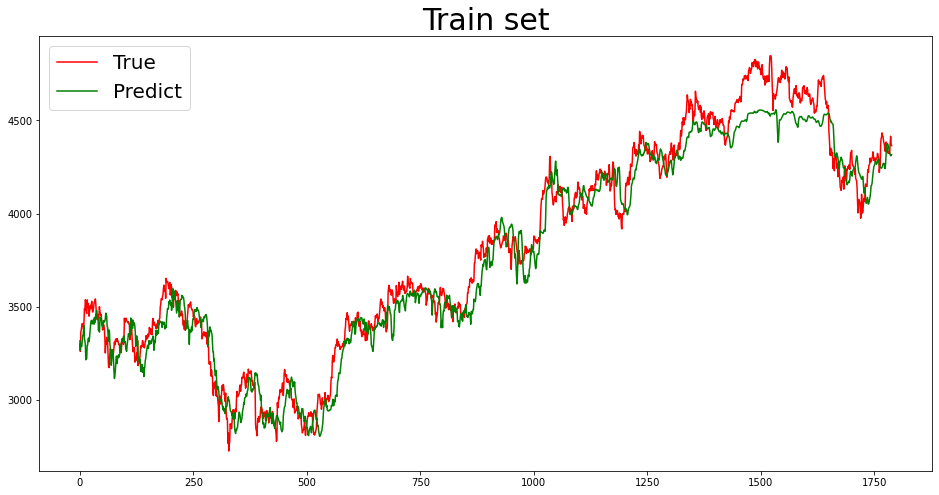

In [38]:
plt.figure(figsize=(16, 8))
y_train_pre = best_model.predict(X_train).reshape(y_train.shape)
plt.plot(y_train,label = 'True',color='red')
plt.plot(y_train_pre,label = 'Predict',color='green')
plt.title('Train set',fontsize=30)

plt.legend(fontsize=20)
plt.show()

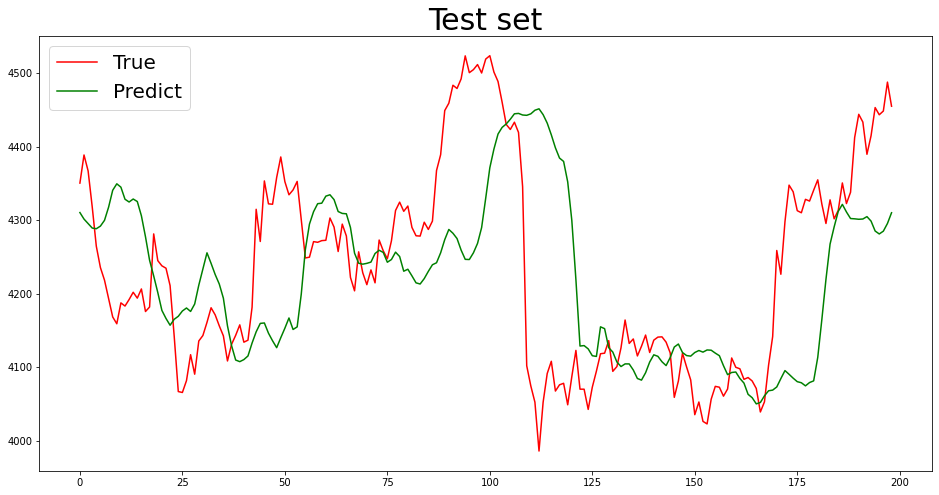

In [39]:
plt.figure(figsize=(16, 8))
y_pre = best_model.predict(X_test).reshape(y_test.shape)
plt.plot(y_test,label = 'True',color='red')
plt.plot(y_pre,label = 'Predict',color='green')
plt.title('Test set',fontsize=30)

plt.legend(fontsize=20)
plt.show()

# 结论及思考

根据真实值和预测值的对比图可以发现，预测值将真实值的大体变化趋势都抓住了。  
但问题在于预测值实际上就是真实值得向后偏移。  
说明模型只是对前几个时间点的数据进行记忆，对未来时间点的数据没有很好的预测能力。


## 查找资料后得到的以下启发：
- 一个可能的解决LSTM预测时序问题滞后的方法是进行差分运算，也就是将当前时刻与上一时刻的差值作为回归目标。(https://github.com/currylym/time-series-prediction-learning-record)
- 可以增大回溯的时间，即增大代码中中的mem_datas，是用更多的数据去预测未来趋势。(https://www.cnblogs.com/xuruilong100/p/8451790.html)
- 由于时间问题以上解决方案均未探索

## 其他量化投资建议
- 最终待预测的日期不要选在周一，周五，法定节假日前一天，法定节假日上班第一天。不稳定因素过多，震荡太大。  
- 近50个交易日的预测mae太大的股票不要考虑，说明这只股票最近可能不按常理出牌导致模型预测不准。  
- 可以预测大盘的涨跌，有些股票的涨跌与大盘的涨跌呈较高的相关性，进而进行佐证。  

